xs                 Open      High       Low  Adj Close    Volume     lag_1  \
Date                                                                      
2024-11-12  2.359723  2.318614  2.252307   2.228217  0.632766 -1.774214   
2024-11-13  2.295451  2.307300  2.244564   2.244551  0.238714  0.087148   
2024-11-14  2.219332  2.173893  2.128613   2.066649  0.177897 -1.669932   
2024-11-15  2.059631  2.125530  2.117620   2.155694  0.096205  0.793128   
2024-11-18  2.340974  2.343343  2.316353   2.323888  0.253554  1.504637   
2024-11-19  2.294612  2.332667  2.342545   2.391651 -0.236341  0.536013   
2024-11-20  2.380805  2.325550  2.357361   2.354596 -0.528911 -0.381126   
2024-11-21  2.369705  2.338233  2.366729   2.332288 -0.637157 -0.256086   
2024-11-22  2.344332  2.461785  2.389862   2.452880 -0.235770  0.998892   

               lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
Date                                                                     
2024-11-12  0.357801  1

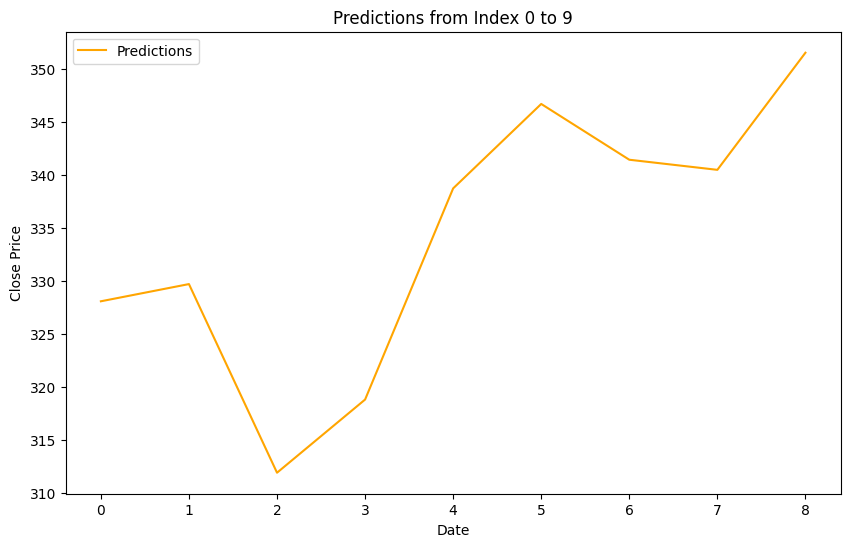

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Function to create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)  # Percentage change
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Function to split the dataset into training and testing sets
def split_data(df, training_period, train_ratio=0.8, idx = None):
    # Create lag features and rolling statistics
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)  # Remove rows with NaN values

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=['Close']).columns, index=df.index)
    scaled_data['Close'] = df['Close']  # Keep original target for splitting

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data['Close'] = target_scaler.fit_transform(df['Close'].values.reshape(-1, 1)).ravel()
    if idx:
        split_idx = idx
        train_data = scaled_data.iloc[:split_idx]
        test_data = scaled_data.iloc[split_idx:]
    else:
        # Split data into training and testing sets
        split_idx = int(len(df) * train_ratio)
        train_data = scaled_data.iloc[:split_idx]
        test_data = scaled_data.iloc[split_idx:]
    # Separate features and targets
    X_train = train_data.drop(columns=['Close'])
    y_train = train_data['Close']
    X_test = test_data.drop(columns=['Close'])
    y_test = test_data['Close']

    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

# Function to train the XGBoost model
def train_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model
# Function to calculate log-return volatility
def calculate_log_volatility(y_values):
    log_returns = np.log(y_values[1:] / y_values[:-1])  # Logarithmic returns
    return np.std(log_returns)  # Volatility as standard deviation of log returns

# Updated evaluate function with average MSE in the legend
def evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler):
    start_indices = [0]#range(0, 30, 5)  # Manually specify starting indices
    for start_idx in start_indices:
        end_idx = start_idx + n_days_to_predict

        # Ensure the model always gets the past 9 days of data
        context_idx = start_idx - 9
        X_context = X_test.iloc[context_idx:start_idx]  # Past 9 days
        X_sub = X_train.iloc[-9:] # recheck on start_25
        print("xs",X_sub)
        y_true = y_test.iloc[start_idx:end_idx]

        # Reshape for LSTM input
        X_sub = X_sub.values.reshape((X_sub.shape[0], X_sub.shape[1]))
        print("xs",X_sub.shape)

        predictions = model.predict(X_sub)
        print(predictions.shape)
        predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
        


        # Plot individual predictions
        plt.figure(figsize=(10, 6))

        plt.plot(np.arange(len(predictions)), predictions, label="Predictions", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"Predictions from Index {start_idx} to {end_idx}")
        plt.legend()
        os.makedirs("../TSLA_pred/xgboost", exist_ok=True)
        plt.savefig(f"../TSLA_pred/xgboost/future.png")
        plt.show()
        plt.close()





# Main function
#def main():
training_period = 9  # Number of days for lag features
n_days_to_predict = 9  # Number of days to predict for each starting point
num_start_points = 9  # Number of unique starting points
path = "../TSLA.csv"  # Path to your stock data file

# Load and preprocess data
headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
df = pd.read_csv(path, names=headers, skiprows=1)
df.replace("null", np.nan, inplace=True)
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
df.set_index("Date", inplace=True)

# Split the dataset into training and testing sets
X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period, idx = -1)


X_train = pd.concat((X_train, X_test))
y_train = pd.concat((y_train, y_test))

# Ensure X_test is an empty DataFrame with the same columns as X_train
X_test = pd.DataFrame(columns=X_train.columns)
# Ensure y_test is an empty Series with the same name as the original y_test
y_test = pd.Series(name=y_test.name)

# Train the XGBOOST model

input_shape = (X_train.shape[1], 1)  # Number of features as input shape

# Train the XGBoost model
model = train_xgboost(X_train, y_train)

# Evaluate predictions for multiple starting points
evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler)

# Run the main function
#if __name__ == "__main__":
#    main()


xs                 Open      High       Low  Adj Close    Volume     lag_1  \
Date                                                                      
2022-06-28  1.443152  1.443805  1.382751   1.333794 -0.216344 -1.456104   
2022-06-29  1.312711  1.272287  1.286491   1.294841 -0.313738 -0.561262   
2022-06-30  1.256834  1.256622  1.253894   1.257350 -0.161638 -0.551286   
2022-07-01  1.280061  1.263679  1.285025   1.283391 -0.423386  0.285082   
2022-07-05  1.242748  1.290293  1.228117   1.337558 -0.291853  0.650377   
2022-07-06  1.315323  1.303220  1.333458   1.325113 -0.457264 -0.220778   
2022-07-07  1.344614  1.401769  1.381476   1.444679 -0.326300  1.479358   
2022-07-08  1.423096  1.489521  1.467030   1.502735 -0.067367  0.647575   
2022-07-11  1.514234  1.472032  1.395018   1.349475 -0.101327 -1.886337   

               lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
Date                                                                     
2022-06-28 -1.127383 -0

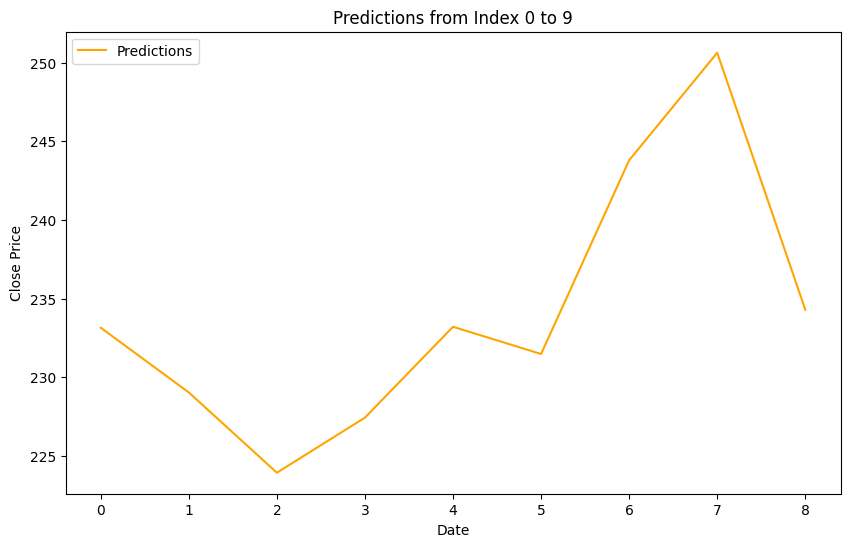

In [ ]:
start_indices = [0]#range(0, 30, 5)  # Manually specify starting indices
for start_idx in start_indices:
    end_idx = start_idx + n_days_to_predict

    # Ensure the model always gets the past 9 days of data
    context_idx = start_idx - 15
    X_context = X_test.iloc[context_idx:start_idx]  # Past 15 days
    X_sub = X_train.iloc[-607:-598] # recheck on start_25 613-598
    print("xs",X_sub)
    y_true = y_test.iloc[start_idx:end_idx]

    # Reshape for LSTM input
    X_sub = X_sub.values.reshape((X_sub.shape[0], X_sub.shape[1]))
    print("xs",X_sub.shape)

    predictions = model.predict(X_sub)
    print(predictions.shape)
    predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
    

    # Plot predictions
    plt.figure(figsize=(10, 6))

    plt.plot(np.arange(len(predictions)), predictions, label="Predictions", color="orange")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title(f"Predictions from Index {start_idx} to {end_idx}")
    plt.legend()
    os.makedirs("../TSLA_pred/xgboost", exist_ok=True)
    plt.savefig(f"../TSLA_pred/xgboost/recheck_25.png")
    plt.show()
    plt.close()